# DistilBERT Encoder Model

In [75]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix,f1_score,accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import json


In [ ]:
import torch
from datasets import Dataset,concatenate_datasets
from transformers import AutoTokenizer,AutoModelForSequenceClassification,TrainingArguments,Trainer,DataCollatorWithPadding

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
train_df = pd.read_csv("../data/raw/train.csv")
val_df   = pd.read_csv("../data/raw/val.csv")
test_df  = pd.read_csv("../data/raw/test.csv")

In [5]:
train_df = train_df[["text","label"]]
val_df   = val_df[["text","label"]]
test_df  = test_df[["text","label"]]

In [6]:
label2id = {"hatespeech": 0,"normal": 1,"offensive": 2}
id2label = {v:k for k,v in label2id.items()}
id2label

{0: 'hatespeech', 1: 'normal', 2: 'offensive'}

In [7]:
train_df["label"] = train_df["label"].map(label2id)
val_df["label"]   = val_df["label"].map(label2id)
test_df["label"]  = test_df["label"].map(label2id)

In [8]:
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

In [9]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [10]:
max_words = 128

def tokenize(batch):
    return tokenizer(batch["text"],padding="max_length",truncation=True,max_length=max_words)

In [11]:
train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [12]:
cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch", columns=cols)

In [13]:
labels = train_ds["label"]

class_counts = torch.bincount(labels)
num_classes = len(class_counts)
total = labels.size(0)

class_weights = total / (num_classes * class_counts.float())
print("class weights:", class_weights)

class weights: tensor([1.0800, 0.8203, 1.1696])


In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels =3,
    id2label = id2label,
    label2id = label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [16]:
training_args = TrainingArguments(
    output_dir="../models/distilbert/checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.00001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    fp16=True,
    num_train_epochs=4,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    report_to="none"
)


In [17]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = torch.nn.CrossEntropyLoss(weight=alpha, reduction="none")

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [18]:
class FocalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = FocalLoss(
            alpha=class_weights.to(logits.device),
            gamma=2
        )

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [19]:
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None, zero_division=0)

    return {
        "accuracy": accuracy_score(labels,preds),
        "macro_f1": f1_score(labels,preds,average="macro"),
        "weighted_f1": f1_score(labels,preds,average="weighted"),
        "precision_hate": precision[0],
        "recall_hate": recall[0],
        "f1_hate": f1[0],
        "precision_normal": precision[1],
        "recall_normal": recall[1],
        "f1_normal": f1[1],
        "precision_offensive": precision[2],
        "recall_offensive": recall[2],
        "f1_offensive": f1[2],
    }

In [20]:
data_collator = DataCollatorWithPadding(tokenizer)

In [21]:
trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,      
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


C:\Users\hario\AppData\Local\Temp\ipykernel_18684\2440521205.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalTrainer.__init__`. Use `processing_class` instead.
  trainer = FocalTrainer(


In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Precision Hate,Recall Hate,F1 Hate,Precision Normal,Recall Normal,F1 Normal,Precision Offensive,Recall Offensive,F1 Offensive
1,0.321600,0.317442,0.629553,0.630983,0.627596,0.728083,0.826307,0.774092,0.799544,0.449424,0.575410,0.455556,0.673358,0.543446
2,0.285600,0.306018,0.676379,0.678361,0.681702,0.789855,0.735245,0.761572,0.754947,0.635083,0.689847,0.516129,0.671533,0.583664
3,0.254700,0.304042,0.687305,0.686945,0.690858,0.766831,0.787521,0.777038,0.778471,0.638924,0.701828,0.528274,0.647810,0.581967
4,0.230800,0.303823,0.680021,0.678551,0.682222,0.741538,0.812816,0.775543,0.784666,0.615877,0.690100,0.522003,0.627737,0.570008


TrainOutput(global_step=1924, training_loss=0.29452721096126055, metrics={'train_runtime': 632.5123, 'train_samples_per_second': 97.282, 'train_steps_per_second': 3.042, 'total_flos': 2037782333832192.0, 'train_loss': 0.29452721096126055, 'epoch': 4.0})

In [23]:
preds = trainer.predict(val_ds)

logits = preds.predictions
y_true = preds.label_ids
y_pred = np.argmax(logits,axis=-1)

In [24]:
wrong_idx = np.where(y_pred != y_true)[0]
len(wrong_idx),len(val_ds)

(601, 1922)

In [25]:
hard_val_ds = val_ds.select(wrong_idx)
hard_boost = concatenate_datasets([hard_val_ds,hard_val_ds])
boosted_train_ds = concatenate_datasets([train_ds, hard_boost])

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels =3,
    id2label = id2label,
    label2id = label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
training_args = TrainingArguments(
    output_dir="../models/distilbert/checkpoints2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.000008,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    fp16=True,
    num_train_epochs=4,
    warmup_ratio=0.05,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    report_to="none"
)


In [28]:
trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=boosted_train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


C:\Users\hario\AppData\Local\Temp\ipykernel_18684\3156783260.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalTrainer.__init__`. Use `processing_class` instead.
  trainer = FocalTrainer(


In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Precision Hate,Recall Hate,F1 Hate,Precision Normal,Recall Normal,F1 Normal,Precision Offensive,Recall Offensive,F1 Offensive
1,0.360800,0.296263,0.656608,0.661821,0.661570,0.784615,0.774030,0.779287,0.792381,0.532650,0.637060,0.476601,0.706204,0.569118
2,0.311100,0.259265,0.687305,0.689332,0.690370,0.782677,0.838111,0.809446,0.819013,0.573624,0.674699,0.508108,0.686131,0.583851
3,0.294900,0.231605,0.737253,0.730604,0.736025,0.792424,0.881956,0.834796,0.792958,0.720871,0.755198,0.599638,0.604015,0.601818
4,0.266200,0.218681,0.723725,0.724760,0.726618,0.815873,0.866779,0.840556,0.833898,0.629962,0.717724,0.548433,0.702555,0.616000


TrainOutput(global_step=2076, training_loss=0.31819225873561263, metrics={'train_runtime': 674.3596, 'train_samples_per_second': 98.375, 'train_steps_per_second': 3.078, 'total_flos': 2197010986583040.0, 'train_loss': 0.31819225873561263, 'epoch': 4.0})

In [31]:
trainer.save_model("../models/distilbert/final_model")
tokenizer.save_pretrained("../models/distilbert/final_model")

('../models/distilbert/final_model\\tokenizer_config.json',
 '../models/distilbert/final_model\\special_tokens_map.json',
 '../models/distilbert/final_model\\vocab.txt',
 '../models/distilbert/final_model\\added_tokens.json',
 '../models/distilbert/final_model\\tokenizer.json')

In [82]:
preds = trainer.predict(val_ds)

logits = preds.predictions
y_true = preds.label_ids
y_pred = np.argmax(logits,axis=-1)

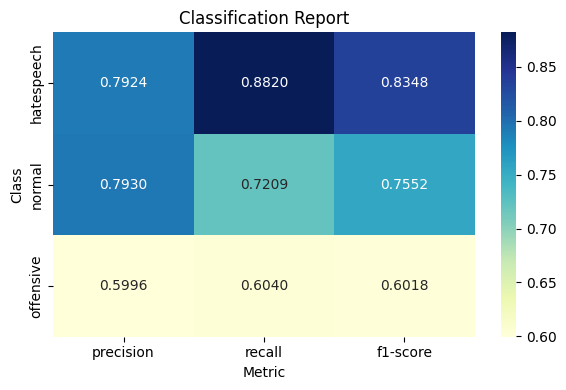

In [84]:
report = classification_report(y_true,y_pred,target_names=["hatespeech","normal","offensive"],output_dict=True)
report
df = pd.DataFrame(report).T
df = df.loc[["hatespeech", "normal", "offensive"], ["precision", "recall", "f1-score"]]

plt.figure(figsize=(6,4))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".4f")

plt.title("Classification Report")
plt.xlabel("Metric")
plt.ylabel("Class")
plt.tight_layout()
plt.savefig("../figures/classific_distilbert.png",dpi=300,bbox_inches='tight')
plt.show()

In [85]:
with open("../results/distilbert/metrics.json","w") as f:
    json.dump(report,f,indent=4)

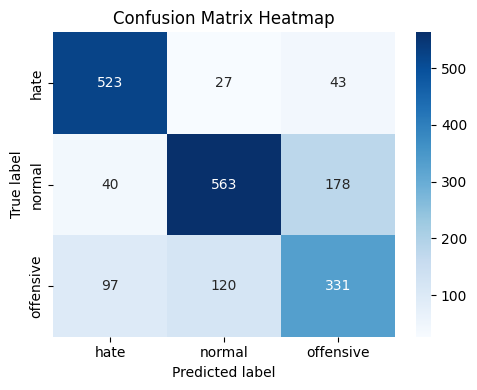

In [87]:
cm = confusion_matrix(y_true, y_pred,labels=[0,1,2])
cm_df = pd.DataFrame(cm, index=["hatespeech", "normal", "offensive"], columns=["hatespeech", "normal", "offensive"])
cm_df.to_csv("../results/distilbert/confusion_matrix.csv")
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["hate","normal","offensive"],
    yticklabels=["hate","normal","offensive"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()

In [89]:
pred_df = val_df.copy()
pred_df["label"] = pred_df["label"].map({0:"hatespeech",1:"normal",2:"offensive"})
pred_df["predicted"] = [id2label[i] for i in y_pred]
pred_df.to_csv("../results/distilbert/predictions.csv", index=False)

In [90]:
trainer.evaluate(test_ds)

{'eval_loss': 0.2990769147872925,
 'eval_accuracy': 0.6637214137214137,
 'eval_macro_f1': 0.6560853068293614,
 'eval_weighted_f1': 0.6643838328180265,
 'eval_precision_hate': 0.7071005917159763,
 'eval_recall_hate': 0.8047138047138047,
 'eval_f1_hate': 0.752755905511811,
 'eval_precision_normal': 0.7661169415292354,
 'eval_recall_normal': 0.6534526854219949,
 'eval_f1_normal': 0.7053140096618358,
 'eval_precision_offensive': 0.49569707401032703,
 'eval_recall_offensive': 0.5255474452554745,
 'eval_f1_offensive': 0.5101860053144376,
 'eval_runtime': 5.4212,
 'eval_samples_per_second': 354.903,
 'eval_steps_per_second': 22.32,
 'epoch': 4.0}

In [91]:
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)
df_logs.head()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_macro_f1,eval_weighted_f1,eval_precision_hate,...,eval_recall_offensive,eval_f1_offensive,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.4918,1.238640,0.000004,0.096432,50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.4841,1.543551,0.000008,0.192864,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.4488,1.510249,0.000008,0.289296,150,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.3978,2.559784,0.000008,0.385728,200,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.3763,3.206507,0.000007,0.482160,250,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
train_logs = df_logs[df_logs["loss"].notna()][["step", "loss", "epoch"]]
eval_logs = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss", "epoch"]]
epoch_train = train_logs.groupby("epoch")["loss"].mean()
epoch_eval = eval_logs.groupby("epoch")["eval_loss"].mean()

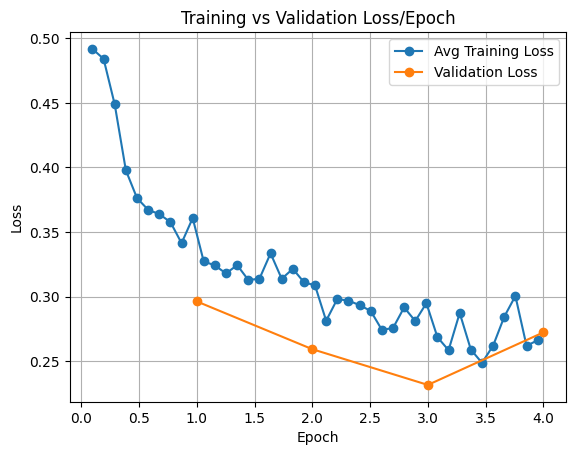

In [ ]:

plt.plot(epoch_train.index, epoch_train.values, marker="o", label="Avg Training Loss")
plt.plot(epoch_eval.index, epoch_eval.values, marker="o", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss/Epoch")
plt.legend()
plt.grid(True)
plt.savefig("../figures/target_frequency.png",dpi=300,bbox_inches="tight")
plt.show()